In [1]:
import re
import json
import os
from typing import Optional, List, Any, Dict, Set, Tuple
import numpy as np
from copy import deepcopy
import random
import wandb
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict

In [2]:
def read_json(fname: str) -> Any:
    """
    Given a filename, reads a json file and returns the data stored inside.

    Input:
        fname (str):
            Name of the file to be read.

    Output:
        data (Any):
            The data loaded from the json file.
    """

    assert os.path.isfile(fname)
    assert fname.endswith(".json")

    with open(fname, "r") as file:
        data = json.load(file)

    return data


def write_json(
    data: Any,
    fname: str,
) -> None:
    """
    Given a data and the filename, writes the data to the specified
    fname.
    If the directory that the specified filename should be in
    does not exist, then it creates the directory first.

    Input:
        data (Any):
            the data that needs to stored in a json format.

        fname (str):
            path to the file where the data needs to be saved.

    Output:
        None
    """

    assert isinstance(fname, str) and fname.endswith(".json")
    splits = fname.split("/")[:-1]
    root_dir = "/".join(splits)
    if not os.path.isdir(root_dir):
        os.makedirs(root_dir, exist_ok=True)

    with open(fname, "w") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

In [3]:
class IrisColormap(matplotlib.colors.ListedColormap):
    """Official IRIS lab plotting color palette. Palette author: Chelsea Finn.

    Recommended usage:
      - Index 0: Your proposed method.
      - Index 1/2: Main comparisons 1/2.
      - Index 3: Main comparison 3 or ablation.
      - Index 4: Main comparison 4 or oracle.
      - Index 5: Main comparison 5. Think about if you really need 6 colors in a
          plot.
    """

    def __init__(self, N: Optional[int] = None):
        """See matplotlib.colors.Colormap for N argument docs."""
        hex_colors = ["#FF6150", "#134E6F", "#1AC0C6", "#FFA822", "#DEE0E6", "#091A29"]

        rgb_colors = [matplotlib.colors.to_rgb(c) for c in hex_colors]
        super().__init__(rgb_colors, name="iris", N=N)

In [4]:
def load_offline_paprika_results(
    path_to_results: str = "/Users/fahimtajwar/academics/exploration/verl/old_data/paprika_compiled_numbers.json",
) -> Dict[str, int]:
    return read_json(fname=path_to_results)

In [8]:
def make_bar_plot_for_particular_environment(
    algorithms_to_data_path: Dict[str, str],
    algorithms: List[str],
    baseline_algorithm: Optional[str],
    temperature: float,
    should_plot: bool,
    environment_name: str,
    best_of_n: bool = False,
) -> defaultdict:
    colors = IrisColormap().colors
    colors = [colors[2], colors[5], colors[0], colors[4]]
    
    offline_paprika_data = load_offline_paprika_results()
    algorithms = deepcopy(algorithms)
    
    _all_environment_num_datapoints = {
        "Twenty Questions": 367,
        "Guess My City": 185,
        "Customer Service": 200,
        "Murder Mystery": 50,
        "Wordle": 800,
        "Cellular Automata": 500,
        "Bandit Best Arm Selection": 100,
        "Minesweeper": 200,
        "Battleship": 200,
        "Mastermind": 500,
    }
    
    # pass @ 4
#     min_values = {
#         "Twenty Questions": 60,
#         "Mastermind": 4.0,
#         "Cellular Automata": 18,
#         "Wordle": 7,
#         "Guess My City": 15.5,
#         "Battleship": 10.0,
#         "Minesweeper": 20,
#         "Bandit Best Arm Selection": 88,
#     }
    
#     max_values = {
#         "Twenty Questions": 72,
#         "Mastermind": 20.0,
#         "Cellular Automata": 24,
#         "Wordle": 14,
#         "Guess My City": 18.0,
#         "Battleship": 30.0,
#         "Minesweeper": 32,
#         "Bandit Best Arm Selection": 100.0,
#     }

    # average
    min_values = {
        "Twenty Questions": 36,
        "Mastermind": 0,
        "Cellular Automata": 3.75,
        "Wordle": 0,
        "Guess My City": 15.5,
        "Battleship": 0,
        "Minesweeper": 0,
        "Bandit Best Arm Selection": 0,
    }
    
    max_values = {
        "Twenty Questions": 44,
        "Mastermind": 40,
        "Cellular Automata": 15,
        "Wordle": 30,
        "Guess My City": 18.0,
        "Battleship": 20,
        "Minesweeper": 15,
        "Bandit Best Arm Selection": 100,
    }
    
    baseline_performance = (
        None
        if baseline_algorithm is None
        else []
    )
    
    relative_performance = defaultdict(list)
    
    relative_success_rate_per_algorithm = []
    
    for index in range(len(algorithms)):
        algorithm = algorithms[index]
        
        if algorithm in [
            "Online Paprika (Single Task)",
            "Online Paprika (All Tasks)",
        ]:
            run_name = algorithms_to_data_path[algorithm][
                "run_name"
            ]
            
            metric_name = algorithms_to_data_path[algorithm][
                "metric_name"
            ]
            
            api = wandb.Api()
            run = api.run(run_name)
            data = np.array(run.history(keys=[metric_name]))[:, 1][-1] * 100
            relative_success_rate_per_algorithm.append(data)
            
        else:
            if algorithms[index] == "Offline Paprika (All Tasks)":
                data = offline_paprika_data[environment_name]["Paprika (Full)"]
            else:
                data = offline_paprika_data[environment_name][algorithm]
                
            relative_success_rate_per_algorithm.append(data)
            
        
            
    if should_plot:            
        bars = plt.bar(
            algorithms,
            relative_success_rate_per_algorithm,
            color=colors,
        )
        
        plt.ylim(min_values[environment_name], max_values[environment_name])
        plt.yticks(
            np.linspace(
                min_values[environment_name], 
                max_values[environment_name], 
                5,
            ),
            fontsize=25,
        )
        
    
    plt.title(environment_name, fontsize=25)
    
    return bars

In [9]:
def make_all_data_bar_plot(
    data_paths: Dict[str, Any],
    environments: List[str],
    algorithms: List[str],
    temperature: float,
    num_rows: int,
    num_cols: int,
    save_path: Optional[str] = None,
    best_of_n: bool = False,
    baseline_algorithm: Optional[str] = None,
) -> None:
    fig = plt.figure(figsize=(35, 10), dpi=300)
    
    all_relative_performance = defaultdict(list)
    
    for index in range(len(environments)):
        should_plot = (index < num_rows * num_cols)
        
        if should_plot:
            plt.subplot(num_rows, num_cols, index + 1)
        
        bars = make_bar_plot_for_particular_environment(
            algorithms_to_data_path=data_paths[environments[index]],
            algorithms=algorithms,
            temperature=temperature,
            environment_name=environments[index],
            best_of_n=best_of_n,
            baseline_algorithm=baseline_algorithm,
            should_plot=should_plot,
        )
        
#         for algorithm in relative_performance:
#             all_relative_performance[algorithm].append(relative_performance[algorithm])
        
        if index == 0:
            leg = fig.legend(
                bars,
                algorithms,
                loc="upper center",
                bbox_to_anchor=(0.5, 0.08),
                fontsize=30,
                ncol=3,
            )
            
        if should_plot:
#             plt.xticks(temperatures, fontsize='xx-large')

#             if index >= num_cols * (num_rows - 1):
#                 plt.xlabel("Temperature", fontsize='xx-large')


            plt.ylabel("Avg Success Rate (%)", fontsize=25)
        
            plt.xticks([])
            
        
    if save_path is not None:
        plt.savefig(
            save_path,
            bbox_inches="tight",
        )
        
    plt.show()

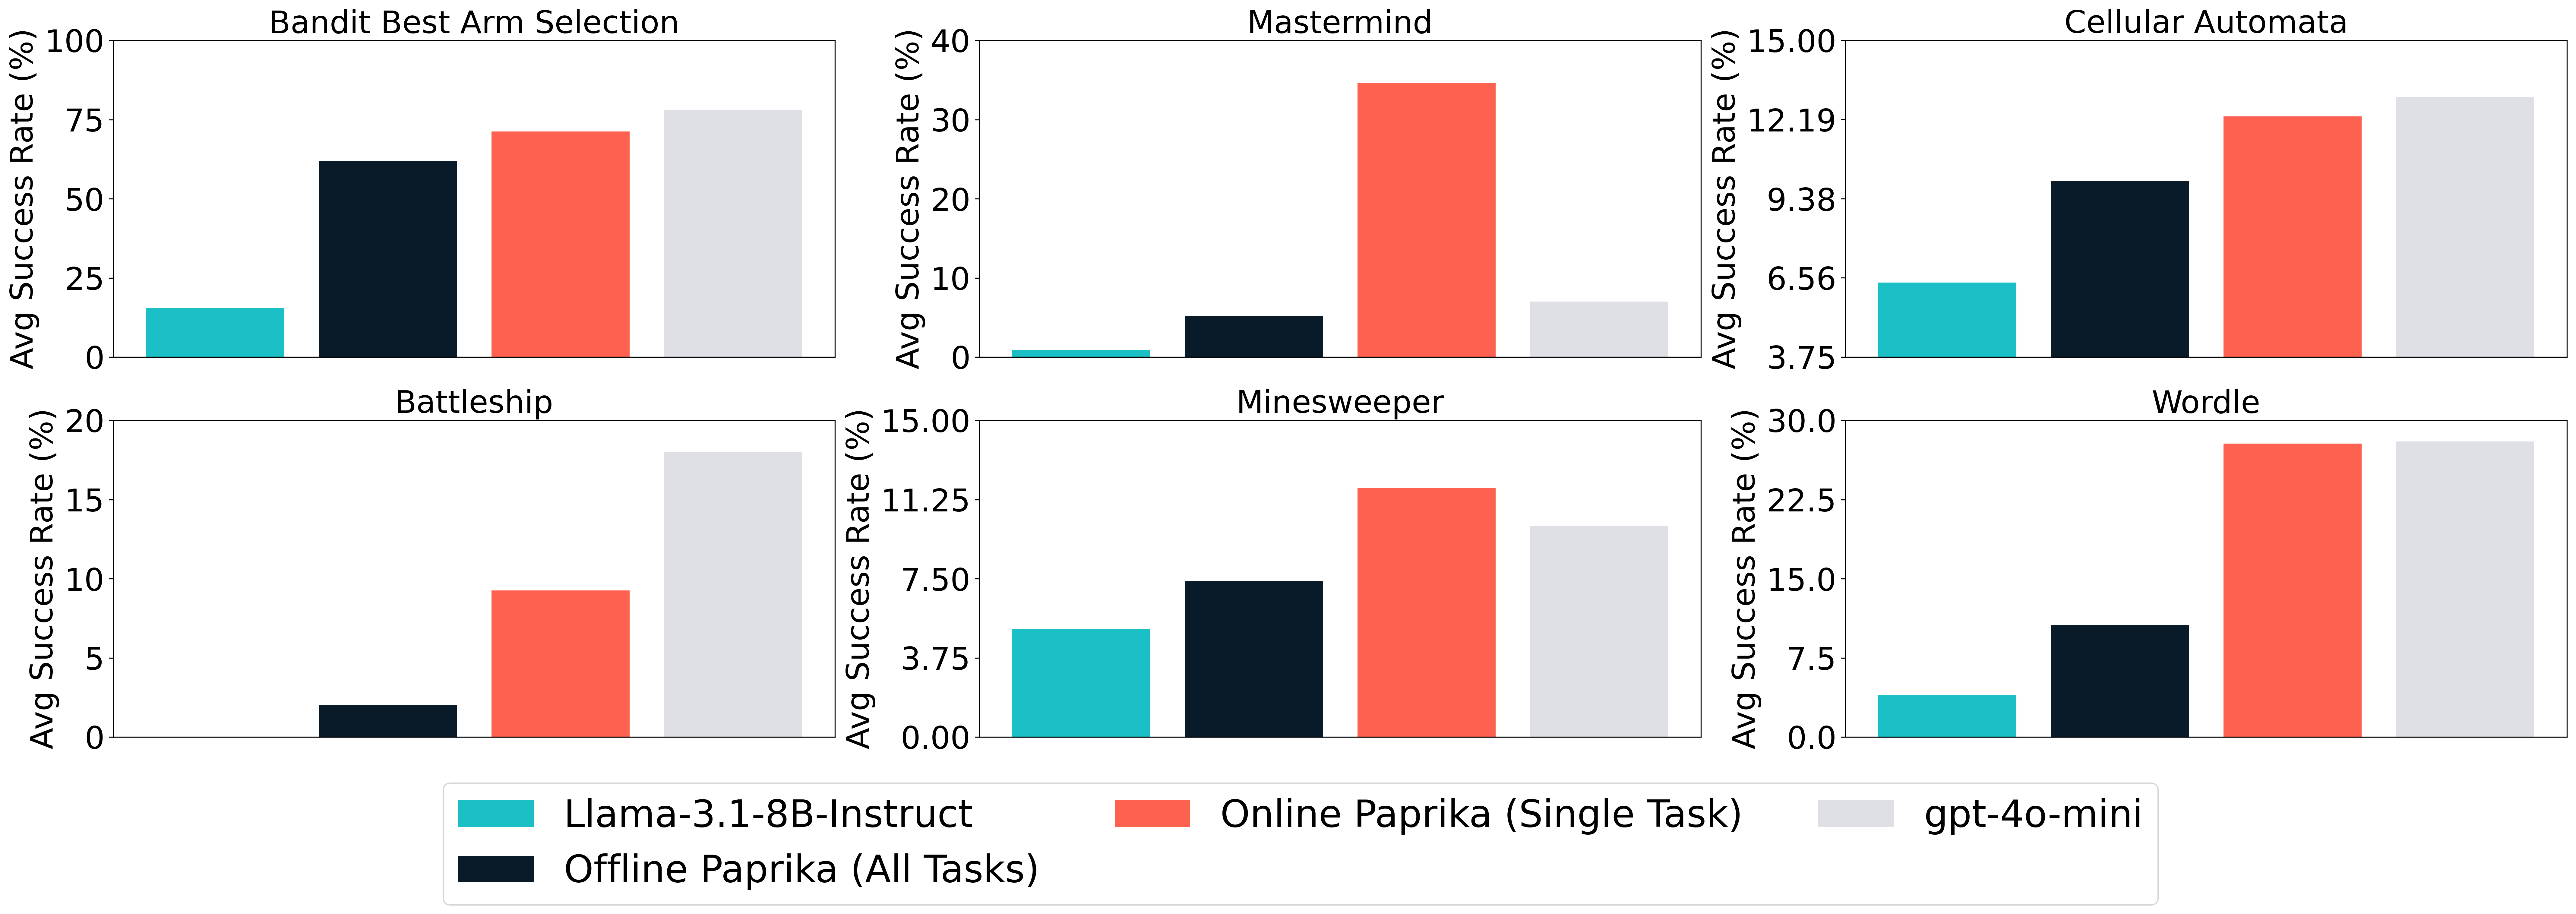

In [10]:
_data_paths = {
    "Bandit Best Arm Selection": {
        "Online Paprika (Single Task)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/tlommkna",
            "metric_name": "val-core/bandit_best_arm_identification/avg@4_success_rate",
        },
        "Online Paprika (All Tasks)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/x95xnilb",
            "metric_name": "val-core/bandit_best_arm_identification/avg@1_success_rate",
        },
    },
    "Mastermind": {
        "Online Paprika (Single Task)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/e1wc8aaa",
            "metric_name": "val-core/mastermind/avg@4_success_rate",
        },
        "Online Paprika (All Tasks)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/x95xnilb",
            "metric_name": "val-core/mastermind/avg@1_success_rate",
        },
    },
    "Cellular Automata": {
        "Online Paprika (Single Task)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/kt9ewbq1",
            "metric_name": "val-core/cellular_automata/avg@4_success_rate",
        },
        "Online Paprika (All Tasks)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/x95xnilb",
            "metric_name": "val-core/cellular_automata/avg@1_success_rate",
        },
    },
    "Battleship": {
        "Online Paprika (Single Task)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/ezu9paon",
            "metric_name": "val-core/battleship/avg@4_success_rate",
        },
        "Online Paprika (All Tasks)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/x95xnilb",
            "metric_name": "val-core/battleship/avg@1_success_rate",
        },
    },
    "Minesweeper": {
        "Online Paprika (Single Task)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/2g7g4nmy",
            "metric_name": "val-core/minesweeper/avg@4_success_rate",
        },
        "Online Paprika (All Tasks)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/x95xnilb",
            "metric_name": "val-core/minesweeper/avg@1_success_rate",
        },
    },
    "Wordle": {
        "Online Paprika (Single Task)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/ziygosk9",
            "metric_name": "val-core/wordle/avg@4_success_rate",
        },
        "Online Paprika (All Tasks)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/x95xnilb",
            "metric_name": "val-core/wordle/avg@1_success_rate",
        },
    },
}


_environments = [
    "Bandit Best Arm Selection",
    "Mastermind",
    "Cellular Automata",
    "Battleship",
    "Minesweeper",
    "Wordle",
]

_algorithms = [
    "Llama-3.1-8B-Instruct",
    "Offline Paprika (All Tasks)",
    "Online Paprika (Single Task)",
#     "Online Paprika (All Tasks)",
    "gpt-4o-mini",
]


make_all_data_bar_plot(
    data_paths=_data_paths,
    environments=_environments,
    algorithms=_algorithms,
    temperature=0.7,
    num_rows=2,
    num_cols=3,
    save_path="/Users/fahimtajwar/academics/exploration/verl/all_plots/single_task_comparisons.png",
)

In [ ]:
def make_per_environment_learning_curve(
    environment_name: str,
    algorithm_to_wandb_path: Dict[str, str],
    algorithm_list: List[str],
    x_axis_name: str,
) -> None:
    colors = IrisColormap().colors
    colors = [colors[2], colors[0], 'green', colors[4]]
    
    for index in range(len(algorithm_list)):
        algorithm = algorithm_list[index]
        
        run_name = algorithm_to_wandb_path[algorithm]["run_name"]
        metric_name = algorithm_to_wandb_path[algorithm]["metric_name"]
        
        api = wandb.Api()
        run = api.run(run_name)
        data = np.array(run.history(keys=[metric_name])) 
            
        if "num_tasks_sampled" not in x_axis_name:
            x_axis = data[:, 0]
            y_axis = data[:, 1]
            
        else:
            x_axis = np.array(run.history(keys=[x_axis_name]))
            x_axis_values = np.cumsum(x_axis[:, 1])
            
            val_name = x_axis_name.replace("train", "val-core")
            x_axis_indices = np.array(run.history(keys=[val_name]))[:, 0]
            
            x_axis = x_axis_values[x_axis_indices[:-1]]
            
            y_axis = data[:, 1][:len(x_axis)]
            
        plt.plot(
            x_axis,
            y_axis,
            color=colors[index],
            markeredgewidth=3,
            markeredgecolor="black",
            marker="o",
            linewidth=7,
            linestyle="-",
        )

In [ ]:
def make_all_environment_learning_curve(
    environment_names: List[str],
    all_algorithm_to_wandb_path: Dict[str, str],
    algorithm_list: List[str],
    x_axis_names: Dict[str, str],
    num_rows: int,
    num_cols: int,
    save_path: Optional[str] = None,
) -> None:
    fig = plt.figure(figsize=(45, 20), dpi=300)
    
    for env_index in range(len(environment_names)):
        env_name = environment_names[env_index]
        
        plt.subplot(num_rows, num_cols, env_index + 1)
        
        make_per_environment_learning_curve(
            environment_name=env_name,
            algorithm_to_wandb_path=all_algorithm_to_wandb_path[env_name],
            algorithm_list=algorithm_list,
            x_axis_name=x_axis_names[env_name],
        )
        
        if env_index == 0:
            leg = fig.legend(
                algorithm_list,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.0),
                fontsize=30,
                ncol=3,
            )
            
        plt.ylabel("Avg Success Rate (%)", fontsize=25)
        plt.xlabel("Gradient Steps", fontsize=25)
        plt.xticks(fontsize=25)
        plt.yticks(fontsize=25)
        plt.title(env_name, fontsize=35)
        
        
    if save_path is not None:
        plt.savefig(
            save_path,
            bbox_inches="tight",
        )
        
    plt.show()

In [ ]:
_data_paths = {
    "Bandit Best Arm Selection": {
        "Online Paprika (Single Task)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/tlommkna",
            "metric_name": "val-core/bandit_best_arm_identification/avg@4_success_rate",
        },
        "Online Paprika (All Tasks), Entropy Bonus: 0.001": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/x95xnilb",
            "metric_name": "val-core/bandit_best_arm_identification/avg@1_success_rate",
        },
        "Online Paprika (All Tasks), Entropy Bonus: 0.0": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/cls1y0ji",
            "metric_name": "val-core/bandit_best_arm_identification/avg@1_success_rate",
        },
    },
    "Mastermind": {
        "Online Paprika (Single Task)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/no5lp6q3",
            "metric_name": "val-core/mastermind/avg@4_success_rate",
        },
        "Online Paprika (All Tasks), Entropy Bonus: 0.001": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/x95xnilb",
            "metric_name": "val-core/mastermind/avg@1_success_rate",
        },
        
        "Online Paprika (All Tasks), Entropy Bonus: 0.0": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/cls1y0ji",
            "metric_name": "val-core/mastermind/avg@1_success_rate",
        },
    },
    "Cellular Automata": {
        "Online Paprika (Single Task)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/kt9ewbq1",
            "metric_name": "val-core/cellular_automata/avg@4_success_rate",
        },
        "Online Paprika (All Tasks), Entropy Bonus: 0.001": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/x95xnilb",
            "metric_name": "val-core/cellular_automata/avg@1_success_rate",
        },
        "Online Paprika (All Tasks), Entropy Bonus: 0.0": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/cls1y0ji",
            "metric_name": "val-core/cellular_automata/avg@1_success_rate",
        },
    },
    "Battleship": {
        "Online Paprika (Single Task)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/ezu9paon",
            "metric_name": "val-core/battleship/avg@4_success_rate",
        },
        "Online Paprika (All Tasks), Entropy Bonus: 0.001": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/x95xnilb",
            "metric_name": "val-core/battleship/avg@1_success_rate",
        },
        "Online Paprika (All Tasks), Entropy Bonus: 0.0": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/cls1y0ji",
            "metric_name": "val-core/battleship/avg@1_success_rate",
        },
    },
    "Minesweeper": {
        "Online Paprika (Single Task)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/2g7g4nmy",
            "metric_name": "val-core/minesweeper/avg@4_success_rate",
        },
        "Online Paprika (All Tasks), Entropy Bonus: 0.001": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/x95xnilb",
            "metric_name": "val-core/minesweeper/avg@1_success_rate",
        },
        "Online Paprika (All Tasks), Entropy Bonus: 0.0": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/cls1y0ji",
            "metric_name": "val-core/minesweeper/avg@1_success_rate",
        },
    },
    "Wordle": {
        "Online Paprika (Single Task)": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/ziygosk9",
            "metric_name": "val-core/wordle/avg@4_success_rate",
        },
        "Online Paprika (All Tasks), Entropy Bonus: 0.001": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/x95xnilb",
            "metric_name": "val-core/wordle/avg@1_success_rate",
        },
        "Online Paprika (All Tasks), Entropy Bonus: 0.0": {
            "run_name": "paprika_online/Llama-3.1-8B-Instruct/cls1y0ji",
            "metric_name": "val-core/wordle/avg@1_success_rate",
        },
    },
}

In [ ]:
_environments = [
    "Bandit Best Arm Selection",
    "Mastermind",
    "Cellular Automata",
    "Battleship",
    "Minesweeper",
    "Wordle",
]

_algorithms = [
    "Online Paprika (Single Task)",
    "Online Paprika (All Tasks), Entropy Bonus: 0.001",
    "Online Paprika (All Tasks), Entropy Bonus: 0.0",
]

# x_axis_names = {
#     "Bandit Best Arm Selection": "train/bandit_best_arm_identification/num_tasks_sampled",
#     "Mastermind": "train/mastermind/num_tasks_sampled",
#     "Cellular Automata": "train/cellular_automata/num_tasks_sampled",
#     "Battleship": "train/battleship/num_tasks_sampled",
#     "Minesweeper": "train/minesweeper/num_tasks_sampled",
#     "Wordle": "train/wordle/num_tasks_sampled",
# }

x_axis_names = {
    "Bandit Best Arm Selection": "train/bandit_best_arm_identification",
    "Mastermind": "train/mastermind",
    "Cellular Automata": "train/cellular_automata",
    "Battleship": "train/battleship",
    "Minesweeper": "train/minesweeper",
    "Wordle": "train/wordle",
}

make_all_environment_learning_curve(
    environment_names=_environments,
    all_algorithm_to_wandb_path=_data_paths,
    algorithm_list=_algorithms,
    num_rows=2,
    num_cols=3,
    x_axis_names=x_axis_names,
    save_path="online_paprika_performance_vs_gradient_steps.png",
)